Colab implementation for

**Multi-echo MRI Reconstruction with Iteratively Refined Zero-shot Spatio-Temporal Deep Generative Prior**

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from numpy import linalg as LA
import scipy.io as sio
import matplotlib.pyplot as plt

import os

from google.colab import drive
drive.mount('/content/gdrive')

import time

# start_time = time.time()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# define functions

# CUDA usage
use_cuda = torch.cuda.is_available()
print('cuda:',use_cuda)


data_path = '/content/gdrive/My Drive/Colab Notebooks/data/'
# data_path = './data/'

def ft2_np(data):
    nx,ny = data.shape[:2]
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(data),axes=(0,1))) / np.sqrt(nx*ny)
    
def ift2_np(data):
    nx,ny = data.shape[:2]
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(data),axes=(0,1))) * np.sqrt(nx*ny)
    
def isumsq(kData):
    return np.sqrt(np.sum(np.abs(ift2_np(kData))**2,axis=2))

# display an image
def showImg(img, name='',v_min=0, v_max=1.5,c_map='gray'):
    plt.axis('off')
#     plt.axis('equal')
    plt.tight_layout()
    if len(name) >0:
        plt.title(name)
    plt.imshow(np.flipud(img), cmap= c_map,vmin = v_min, vmax=v_max)

# display list of images 
def display_all(img,v_min=0, v_max=1.5):
    if img.ndim < 3:
        showImg(img)
    else:
        num_img = img.shape[2]
        num_rows = int(np.floor(np.sqrt(num_img)))
        num_cols = int(np.ceil( num_img / num_rows ))

        for k in range(num_img):
            plt.subplot(num_rows,num_cols, k+1)
            showImg(img[:,:,k],v_min=v_min,v_max=v_max)
            if k+1 == num_cols:
                plt.show()
    plt.show()



cuda: True


Image Dimensions:  206 176 32 5
Gold Standard


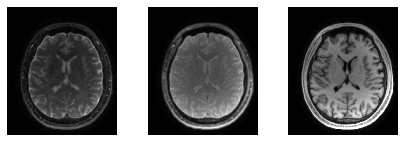

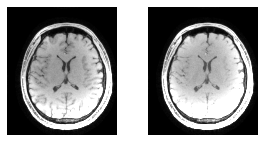

In [3]:
# Coil sensitivity
coil_sens = sio.loadmat(data_path + 'QALAS_data.mat')['coil_sens']
coil_sens = coil_sens[:,:,:,None]

# Raw k-space data 
kData = sio.loadmat(data_path+'QALAS_data.mat')['kData']


# Data size
nx, ny, nc, ne = kData.shape


print('Image Dimensions: ',nx, ny, nc, ne)


# Gold Standard (ideal) images
ideal = (coil_sens.conj()*ift2_np( kData )).sum(2) / ((abs(coil_sens)**2).sum(2)+np.finfo(float).eps);
print('Gold Standard')
display_all(abs(ideal))


acc: 16x
Sampling Masks


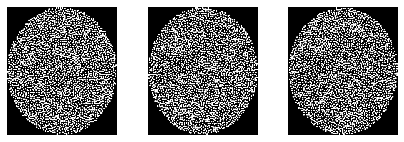

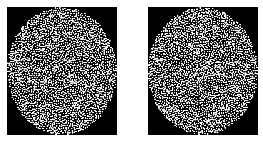

In [4]:
# Sampling mask 
kMask = sio.loadmat(data_path+'kMask12x.mat')['kMask']

acc = np.prod(kMask.shape) / kMask.sum()
acc = int(np.round(acc))
print('acc: ' + str(acc) + 'x')


mask = torch.tensor(kMask.transpose(2,3,0,1))[None,...,None]
if use_cuda:
    mask = mask.cuda()

print('Sampling Masks')
display_all(kMask[:,:,0,:],v_max = 0.1)

In [5]:
coilc = torch.tensor(coil_sens.transpose(2,3,0,1),dtype = torch.cfloat) 
datc = torch.tensor((kData*kMask).transpose(2,3,0,1),dtype=torch.cfloat)[None,:,:,:,:]
maskc = torch.tensor(kMask.transpose(2,3,0,1))[None,...]


if use_cuda:
    coilc, datc, maskc = coilc.cuda(), datc.cuda(), maskc.cuda()

# 2D Fourier 
def ft2c(x):
    return torch.fft.fftshift(torch.fft.fft2(torch.fft.ifftshift(x), dim = (-1,-2), norm = "ortho"))

# 2D Inverse Fourier
def ift2c(x):
    return torch.fft.fftshift(torch.fft.ifft2(torch.fft.ifftshift(x), dim = (-1,-2), norm = "ortho"))

# Forward model
def Ac(x):
    return maskc * ft2c(coilc * x[:,None,...])

# Its Hermitian
def Ahc(x):
    return (torch.conj(coilc)*ift2c(maskc*x)).sum(1)

# Inner product
def inner_c(x,y):
    return (torch.conj(x) * y).sum(list(range(1,x.dim())) )


MSE = nn.MSELoss()

# MSE for complex tensors
def MSEc(x, y):
    return MSE(torch.view_as_real(x), torch.view_as_real(y))

SENSE Reconstruction
iter 0 , residue 8.770937
iter 10 , residue 0.41313204
iter 20 , residue 0.13229579
iter 30 , residue 0.06367178
iter 40 , residue 0.03547466
CG-SENSE results (Naive Recon)


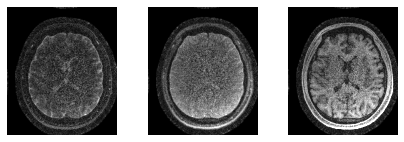

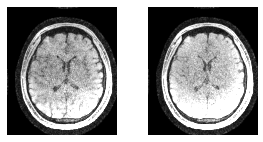

In [6]:
# CG-SENSE 


print('SENSE Reconstruction') 

x = Ahc(datc) 
if use_cuda:
    x = x.cuda()


r = Ahc(datc) - Ahc(Ac(x))
p = r
rsold = torch.norm(r, 'fro') **2

for it in range(50):
    z = Ahc(Ac(p))
    alpha = rsold / inner_c(p, z)
    x = x + alpha * p
    r = r - alpha * z
    rsnew = torch.norm(r, 'fro')**2

    if (it) % 10 == 0:
        print('iter', it, ', residue',np.sqrt(rsnew.cpu().numpy())) 

    if torch.sqrt(rsnew) < 1e-6:
        break
    p = r + (rsnew / rsold) * p
    rsold = rsnew


sense_tensor = x

recon = x.squeeze()


if use_cuda:
    recon = recon.cpu()



recon = recon.numpy().transpose(1,2,0)
sense = recon



print('CG-SENSE results (Naive Recon)')
display_all(abs(recon))



In [7]:
# Define generative network 
class GenNet(nn.Module):
    def __init__(self, in_channels=10, out_channels=10):
        super(GenNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 48, 3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(48, 48, 3, stride=2, padding=1, output_padding=1, bias=False))

        self.layer2 = nn.Sequential(
            nn.Conv2d(48, 96, 3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1, bias=False))

        self.layer3 = nn.Sequential(
            nn.Conv2d(96, 96, 3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 3, stride=2, padding=1, output_padding=1, bias=False))

        self.layer4 = nn.Sequential(
            nn.Conv2d(96 , 64, 3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, 3, stride=1, padding=1, bias=False))
            
        # Initialize weights
        self._init_weights()


    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                # m.bias.data.zero_()


    def forward(self, x):
        upsample5 = self.layer1(x)
        upsample4 = self.layer2(upsample5)
        upsample3 = self.layer3(upsample4)
        upsample2 = self.layer3(upsample3)
        upsample1 = self.layer3(upsample2)
        return self.layer4(upsample1)

**Deep Generative Prior Reconstruction**

In [8]:
# Run Generative Network
def run_GenNet(model,input,cur_recon, epoch = 5001,lr=1e-3):
        
    ext_recon = np.pad(cur_recon,((25,25),(40,40),(0,0)),'constant')
    target = torch.view_as_real(torch.tensor(ext_recon,dtype = torch.cfloat))
    target = torch.cat((target[...,0],target[...,1]),dim=-1).permute(2,0,1)[None]

    if use_cuda:
        target = target.cuda()


    optimizer = optim.AdamW(model.parameters(), lr=lr)
    # optimizer = optim.Adam(model.parameters(), lr=lr)

    for k in range(epoch):
        optimizer.zero_grad()

        x = input
        if use_cuda:
            x = x.cuda()
            target = target.cuda()

        a = model(x)

        loss = MSE(a, target)

        if k%1000 == 0:
            if use_cuda:
                print('loss: ' + str(loss.cpu().detach().numpy()))
            else:
                print('loss: ' + str(loss.detach().numpy()))
        loss.backward()
        optimizer.step()


    ti = a[0].detach().permute(1,2,0).cpu().numpy()
    tmp= ti[...,:5] + 1j*ti[...,5:]
    rec = torch.tensor(tmp[25:-25,40:-40,:]).permute(2,0,1)[None].cuda()

    return rec



In [9]:
# Run Reconstruction using deep generative prior
def SENSE_reg(rec=0, iter=50, lmbd=1e-1 ):

    x = Ahc(datc) 
    if use_cuda:
        x = x.cuda()

    r = (Ahc(datc)+lmbd*rec) - (Ahc(Ac(x)) + lmbd*(x))
    p = r
    rsold = torch.norm(r, 'fro') **2

    for it in range(iter):
        z = Ahc(Ac(p)) + lmbd*(p)
        alpha = rsold / inner_c(p, z)
        x = x + alpha * p
        r = r - alpha * z
        rsnew = torch.norm(r, 'fro')**2

        if torch.sqrt(rsnew) < 1e-6:
            break
        p = r + (rsnew / rsold) * p
        rsold = rsnew

    sense_tensor = x

    recon = x.squeeze()

    if use_cuda:
        recon = recon.cpu()

    recon = recon.numpy().transpose(1,2,0)

    display_all(abs(recon))

    return recon


Initial Reconstruction


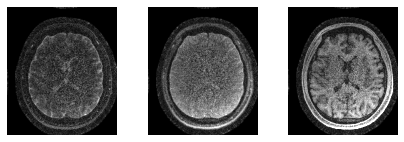

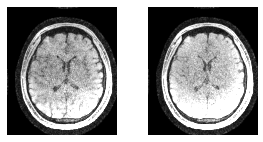

In [10]:
# Initialization
print('Initial Reconstruction')
cur_recon = SENSE_reg(lmbd = 0)

In [11]:
# Spatio-temporal deep generative prior

in_ch = 36
model = GenNet(in_channels=in_ch, out_channels=2*ne)
if use_cuda:
    model = model.cuda()


input = torch.rand(1,in_ch,8,8)


EPOCH: 1
Training Generative Network
loss: 0.24061094
loss: 0.010270576
loss: 0.006716286
Image Reconstruction


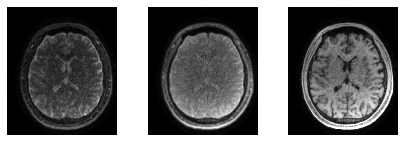

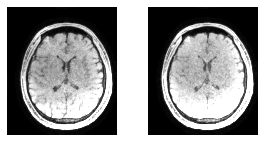

EPOCH: 2
Training Generative Network
loss: 0.0015554938
loss: 0.0073074326
loss: 0.004672773
Image Reconstruction


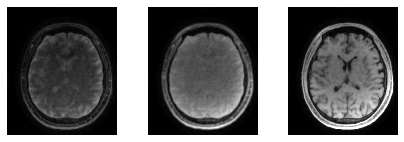

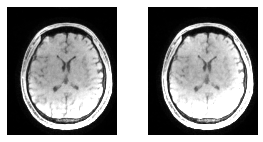

EPOCH: 3
Training Generative Network
loss: 0.0006962595
loss: 0.0009587418
loss: 0.013496487
Image Reconstruction


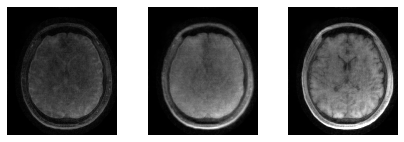

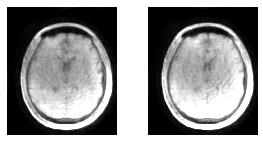

EPOCH: 4
Training Generative Network
loss: 0.003107541
loss: 0.0011940405
loss: 0.0009533746
Image Reconstruction


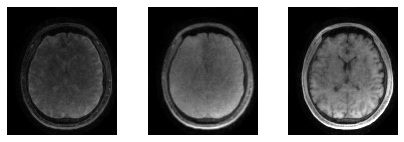

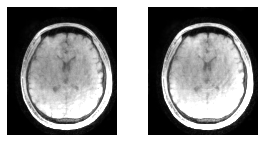

EPOCH: 5
Training Generative Network
loss: 0.0013462189
loss: 0.000980439
loss: 0.00076622097
Image Reconstruction


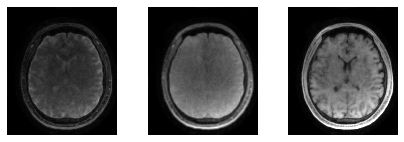

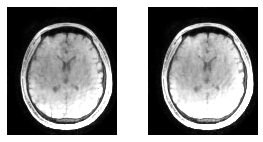

EPOCH: 6
Training Generative Network
loss: 0.00086151203
loss: 0.00078721176
loss: 0.0013482039
Image Reconstruction


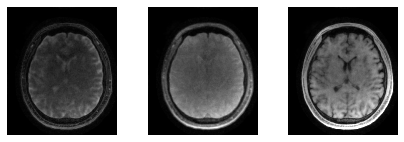

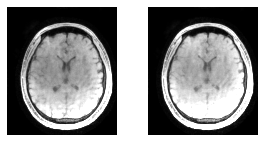

EPOCH: 7
Training Generative Network
loss: 0.003506725
loss: 0.0005190658
loss: 0.0003824937
Image Reconstruction


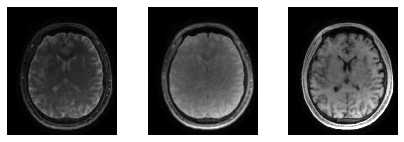

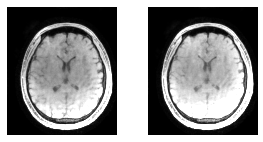

EPOCH: 8
Training Generative Network
loss: 0.0004465576
loss: 0.00033210864
loss: 0.00044940805
Image Reconstruction


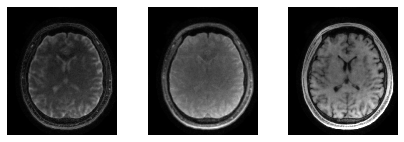

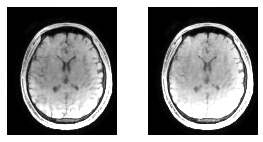

EPOCH: 9
Training Generative Network
loss: 0.0007239743
loss: 0.00027972637
loss: 0.00027074676
Image Reconstruction


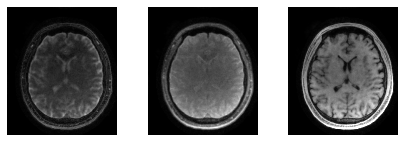

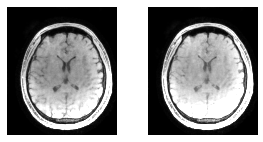

EPOCH: 10
Training Generative Network
loss: 0.00033893524
loss: 0.00025323426
loss: 0.00023754421
Image Reconstruction


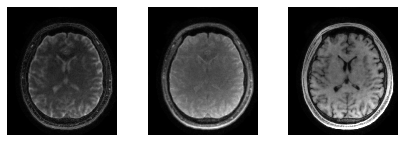

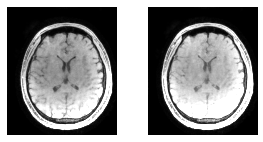

EPOCH: 11
Training Generative Network
loss: 0.0002519333
loss: 0.00023258808
loss: 0.00022004652
Image Reconstruction


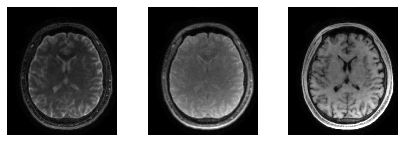

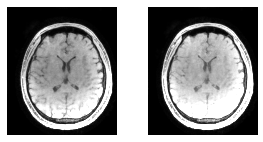

EPOCH: 12
Training Generative Network
loss: 0.00023188535
loss: 0.00024343841
loss: 0.00021576979
Image Reconstruction


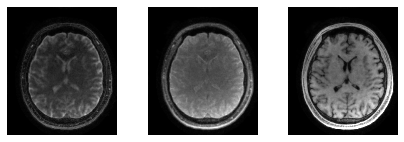

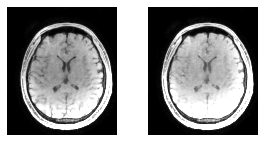

EPOCH: 13
Training Generative Network
loss: 0.0002262151
loss: 0.00021431931
loss: 0.00025922313
Image Reconstruction


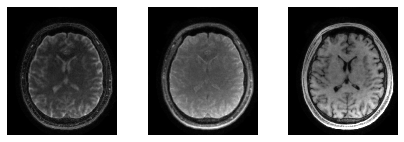

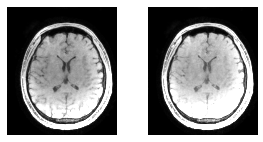

EPOCH: 14
Training Generative Network
loss: 0.00042686425
loss: 0.00019963505
loss: 0.00018899167
Image Reconstruction


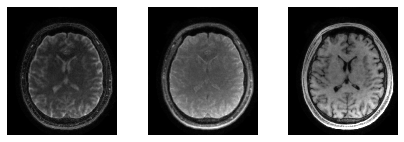

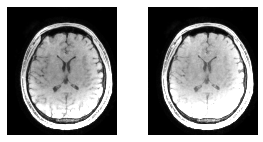

EPOCH: 15
Training Generative Network
loss: 0.00019467
loss: 0.00020519698
loss: 0.00020029981
Image Reconstruction


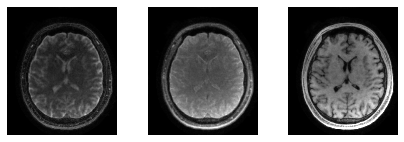

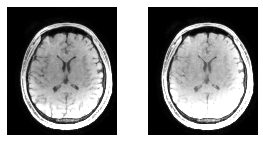

In [12]:
# Proposed multi-echo reconstruction with deep generative prior

learning_rate = 1e-3
for epoch in range(15):
    print("EPOCH:", epoch+1)
    print("Training Generative Network")
    gen_img = run_GenNet(model,input,cur_recon, epoch = 2001,lr = learning_rate)
    print("Image Reconstruction")
    cur_recon = SENSE_reg(gen_img)


Proposed Reconstruction


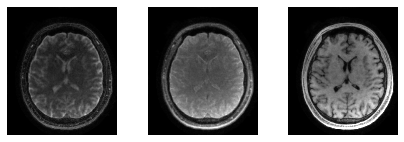

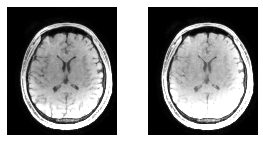

In [16]:
print("Proposed Reconstruction")
display_all(abs(cur_recon))

# print("Recontime: ", (time.time() - start_time) , 's')
